In [2]:
import numpy as np
import h5py

import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

import json
import os

## South Africa

### Counts

In [3]:
data_dir = '/work/ka1176/shared_data/2021-ai4food/raw_data/'

In [4]:
south_africa_tr_labels_dir_1 = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_258N/labels.geojson')
south_africa_tr_labels_dir_2 = os.path.join(data_dir, 'ref_fusion_competition_south_africa_train_labels/ref_fusion_competition_south_africa_train_labels_34S_19E_259N/labels.geojson')
south_africa_te_labels_dir = os.path.join(data_dir, 'ref_fusion_competition_south_africa_test_labels/ref_fusion_competition_south_africa_test_labels_34S_20E_259N/labels.geojson')

In [5]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:
south_africa_tr_labels_1=gpd.read_file(south_africa_tr_labels_dir_1)
south_africa_tr_labels=south_africa_tr_labels_1.append(gpd.read_file(south_africa_tr_labels_dir_2))
print('INFO: Number of fields: {}\n'.format(len(south_africa_tr_labels)))
south_africa_te_labels=gpd.read_file(south_africa_te_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(south_africa_te_labels)))

INFO: Number of fields: 4151

INFO: Number of fields: 2417



In [6]:
south_africa_tr_labels = south_africa_tr_labels.sort_values('crop_id')

In [7]:
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 

In [8]:
value_counts = south_africa_tr_labels['crop_name'].value_counts(sort=False)
value_counts

Wheat                   753
Barley                  661
Canola                  512
Lucerne/Medics         1792
Small grain grazing     433
Name: crop_name, dtype: int64

In [9]:
df = pd.DataFrame(dict(crop_counts=value_counts.values, crop_names=value_counts.index))

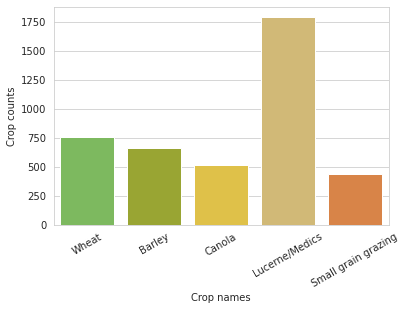

In [10]:
sns.set_style('whitegrid')
ax=sns.barplot(data=df, x='crop_names', y='crop_counts', palette=sns.color_palette(colors_list))
ax.set_xlabel('Crop names')
ax.set_xticks(range(5))
ax.set_xticklabels(value_counts.index, rotation=30)
ax.set_ylabel('Crop counts')
plt.savefig('../final/fig_south_africa_crop_id_barplot.png', dpi=150, bbox_inches="tight")

### Bands

In [11]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/south-africa/planet-5/extracted/train_data.h5', 'r')
image_stack = train_data['image_stack'][:]
labels = train_data['label'][:]

train_data_s1 = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/south-africa/sentinel-1/extracted/train_data.h5', 'r')
image_stack_s1 = train_data_s1['image_stack'][:]
labels = train_data_s1['label'][:]


crop_ids, inv_idx, counts = np.unique(labels, return_inverse=True, return_counts=True)

for u,c in zip(crop_ids, counts):
    print(f'Crop ID {u}: {c} samples')
    
def calc_ndvi(image_stack):
    nir = image_stack[:, 3]
    red = image_stack[:, 2]
    
    ndvi = (nir - red) / (nir + red)
    
    ndvi = np.nan_to_num(ndvi)
    
    return ndvi

def calc_rvi(image_stack):
    VV = image_stack[:, 0]
    VH = image_stack[:, 1]
    
    dop = (VV/(VV+VH))
    m = 1 - dop
    radar_vegetation_index = (np.sqrt(dop))*((4*(VH))/(VV+VH))

    eps = 1e-9 # avoid zero values
    radar_vegetation_index = np.nan_to_num(radar_vegetation_index, nan=eps, posinf=eps, neginf=eps)

    return radar_vegetation_index
    

Crop ID 1: 751 samples
Crop ID 2: 660 samples
Crop ID 3: 512 samples
Crop ID 4: 1788 samples
Crop ID 5: 432 samples


In [12]:
t_planet = np.linspace(0, 180, 48)
t_sentinel1 = np.linspace(0, 180, 41)

1
2
3
4
5


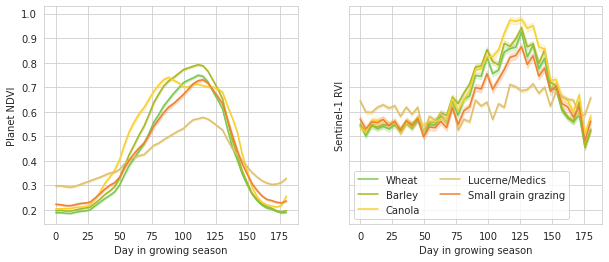

In [13]:
fig, axx = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 4])

for crop_id in range(1, 6):
    print(crop_id)
    ix = np.where(labels==crop_id)[0]

    crop_ndvi = np.empty([len(ix)+1, 48, 64])
    crop_ndvi[:] = None
    
    crop_rvi = np.empty([len(ix)+1, 41, 64])

    for j,i in enumerate(ix):
        img = image_stack[i]
        crop_ndvi[j] = calc_ndvi(img)
        
        img = image_stack_s1[i]
        crop_rvi[j] = calc_rvi(img)
        
    m_ndvi = np.nanmean(crop_ndvi, axis=(0,2))
    s_ndvi = np.nanstd(crop_ndvi, axis=(0,2)) / np.sqrt(len(ix))
    
    m_rvi = np.nanmean(crop_rvi, axis=(0,2))
    s_rvi = np.nanstd(crop_rvi, axis=(0,2)) / np.sqrt(len(ix))
    
    axx[0].plot(t_planet, m_ndvi, color=colors_list[crop_id-1], label=pd.unique(df.crop_names)[crop_id-1])
    axx[0].fill_between(t_planet, m_ndvi + s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])
    axx[0].fill_between(t_planet, m_ndvi - s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])
    
    axx[1].plot(t_sentinel1, m_rvi, color=colors_list[crop_id-1], label=pd.unique(df.crop_names)[crop_id-1])
    axx[1].fill_between(t_sentinel1, m_rvi + s_rvi, m_rvi, alpha=0.2, color=colors_list[crop_id-1])
    axx[1].fill_between(t_sentinel1, m_rvi - s_rvi, m_rvi, alpha=0.2, color=colors_list[crop_id-1])


axx[1].legend(loc=3, ncol=2)
axx[0].set_xlabel('Day in growing season')
axx[0].set_ylabel('Planet NDVI')

axx[1].set_xlabel('Day in growing season')
axx[1].set_ylabel('Sentinel-1 RVI')

plt.savefig('../final/fig_south_africa_crop_id_ndvi.png', dpi=150, bbox_inches="tight")

### Submission

In [14]:
with open('/work/ka1176/caroline/gitlab/ai4foodsecurity/final_submission_south_africa/submission.json') as sf:
    best_submission = json.load(sf)

In [15]:
df = pd.DataFrame.from_dict(best_submission)
df.columns = ['fid', 'predicted_crop_id', 'predicted_crop_name', 'crop_probs']

In [16]:
new_df = south_africa_te_labels.merge(df, on='fid')
new_df = new_df.sort_values('predicted_crop_id')
new_df

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry,predicted_crop_id,predicted_crop_name,crop_probs
2086,190733,249015.237020,2155.626918,0,No Data,"MULTIPOLYGON (((500219.961 6220444.988, 500190...",1,Wheat,"[0.7222279072, 0.0940098744, 0.005779697, 0.01..."
713,187596,182198.400073,2198.936009,0,No Data,"MULTIPOLYGON (((486402.428 6224677.303, 486382...",1,Wheat,"[0.4283527203, 0.0439218465, 0.0025541502, 0.2..."
2168,190844,347619.223825,2374.588350,0,No Data,"MULTIPOLYGON (((502475.364 6221393.085, 502458...",1,Wheat,"[0.6782460243, 0.2651202796, 0.0068927593, 0.0..."
1851,190306,105487.950223,1415.954947,0,No Data,"MULTIPOLYGON (((501148.537 6226518.402, 501128...",1,Wheat,"[0.4647373885, 0.2195927691, 0.0071762192, 0.0..."
1475,189634,77548.872320,1201.986864,0,No Data,"MULTIPOLYGON (((502682.022 6230141.152, 502696...",1,Wheat,"[0.4544349492, 0.2877589729, 0.0140097077, 0.0..."
...,...,...,...,...,...,...,...,...,...
1046,188164,72713.844868,1194.184369,0,No Data,"MULTIPOLYGON (((480281.146 6231910.680, 480165...",5,Small grain grazing,"[0.1116916103, 0.026024298, 0.0001140041, 0.24..."
521,187110,97993.123781,1551.294924,0,No Data,"MULTIPOLYGON (((487182.862 6234279.767, 487190...",5,Small grain grazing,"[0.1249026744, 0.0279057026, 0.000997775, 0.25..."
1612,189999,19821.272262,580.335197,0,No Data,"MULTIPOLYGON (((493345.430 6228361.251, 493366...",5,Small grain grazing,"[0.0250845664, 0.0853431175, 0.0022463678, 0.4..."
510,187096,81354.119365,1205.236813,0,No Data,"MULTIPOLYGON (((486008.705 6232797.899, 486077...",5,Small grain grazing,"[0.33322748, 0.0107660762, 0.0011649371, 0.095..."


Wheat
Barley
Canola
Lucerne/Medics
Small grain grazing


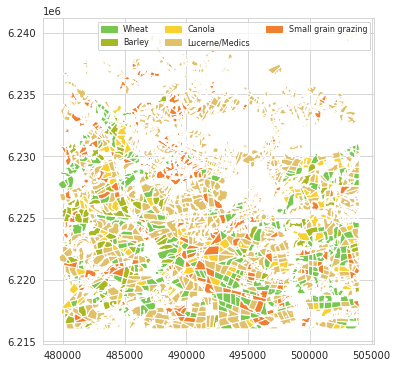

In [17]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

legend_elements = []

for group, color in zip(new_df.groupby('predicted_crop_name', sort=False), colors_list):
    print(group[0])
    group[1].plot(ax=ax, color=color)
    legend_elements.append(Patch(facecolor=color, edgecolor=color,label=group[0]))
    
ax.legend(handles=legend_elements,loc=1, ncol=3, fontsize=8)

plt.savefig('../final/fig_south_africa_predictions_map.png', dpi=150, bbox_inches="tight")

## Germany

### Counts

In [38]:
data_dir = '/work/ka1176/shared_data/2021-ai4food/raw_data/'

In [39]:
germany_train_labels_dir = os.path.join(data_dir, 'dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')
germany_test_labels_dir = os.path.join(data_dir, 'dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/labels.geojson')

In [40]:
#CHECK TARGET DATA FORMAT IN TRAINING GROUND-TRUTH POLYGONS:
germany_train_labels=gpd.read_file(germany_train_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(germany_train_labels)))
germany_test_labels=gpd.read_file(germany_test_labels_dir)
print('INFO: Number of fields: {}\n'.format(len(germany_test_labels)))

INFO: Number of fields: 2534

INFO: Number of fields: 2064



In [41]:
germany_train_labels = germany_train_labels.sort_values('crop_id')

In [42]:
colors_list = ['#78C850','#A8B820','#F8D030','#E0C068', '#F08030', '#C03028', '#F85888','#6890F0','#98D8D8'] 

In [43]:
value_counts = germany_train_labels['crop_name'].value_counts(sort=False)
value_counts

Wheat           305
Rye             279
Barley          137
Oats             45
Corn            251
Oil Seeds       201
Root Crops       23
Meadows         954
Forage Crops    339
Name: crop_name, dtype: int64

In [44]:
df = pd.DataFrame(dict(crop_counts=value_counts.values, crop_names=value_counts.index))

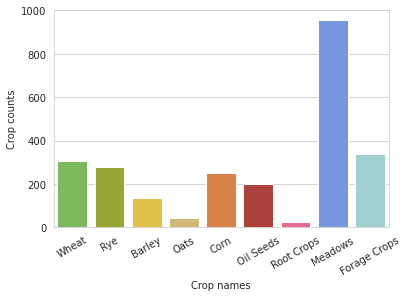

In [45]:
sns.set_style('whitegrid')
ax=sns.barplot(data=df, x='crop_names', y='crop_counts', palette=sns.color_palette(colors_list))
ax.set_xlabel('Crop names')
ax.set_xticks(range(9))
ax.set_xticklabels(value_counts.index, rotation=30)
ax.set_ylabel('Crop counts')
plt.savefig('../final/fig_germany_crop_id_barplot.png', dpi=150, bbox_inches="tight")

### Bands

In [46]:
train_data = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/planet-5/extracted/train_data.h5', 'r')
image_stack = train_data['image_stack'][:]
labels = train_data['label'][:]

train_data_s1 = h5py.File('/work/ka1176/shared_data/2021-ai4food/dev_data/germany/sentinel-1/extracted/train_data.h5', 'r')
image_stack_s1 = train_data_s1['image_stack'][:]
labels = train_data_s1['label'][:]

crop_ids, inv_idx, counts = np.unique(labels, return_inverse=True, return_counts=True)

for u,c in zip(crop_ids, counts):
    print(f'Crop ID {u}: {c} samples')
    
def calc_ndvi(image_stack):
    nir = image_stack[:, 3]
    red = image_stack[:, 2]
    
    ndvi = (nir - red) / (nir + red)
    
    ndvi = np.nan_to_num(ndvi)
    
    return ndvi

Crop ID 1: 302 samples
Crop ID 2: 276 samples
Crop ID 3: 136 samples
Crop ID 4: 44 samples
Crop ID 5: 248 samples
Crop ID 6: 201 samples
Crop ID 7: 21 samples
Crop ID 8: 943 samples
Crop ID 9: 333 samples


1
2
3
4
5
6
7
8
9


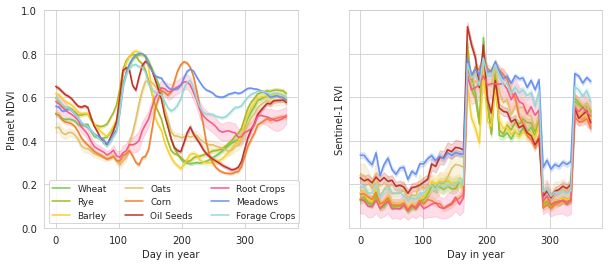

In [47]:
fig, axx = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 4])

t_planet = np.linspace(0, 365, 73)
t_sentinel1 = np.linspace(0, 365, 59)

for crop_id in range(1, 10):
    print(crop_id)
    ix = np.where(labels==crop_id)[0]

    crop_ndvi = np.empty([len(ix)+1, 73, 64])
    crop_ndvi[:] = None
    
    crop_rvi = np.empty([len(ix)+1, 59, 64])

    for j,i in enumerate(ix):
        img = image_stack[i]
        crop_ndvi[j] = calc_ndvi(img)
        
        img = image_stack_s1[i]
        crop_rvi[j] = calc_rvi(img[::2])
        
    m_ndvi = np.nanmean(crop_ndvi, axis=(0,2))
    s_ndvi = np.nanstd(crop_ndvi, axis=(0,2)) / np.sqrt(len(ix))
    
    m_rvi = np.nanmean(crop_rvi, axis=(0,2))
    s_rvi = np.nanstd(crop_rvi, axis=(0,2)) / np.sqrt(len(ix))
    
    axx[0].plot(t_planet, m_ndvi, color=colors_list[crop_id-1], label=pd.unique(df.crop_names)[crop_id-1])
    axx[0].fill_between(t_planet, m_ndvi + s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])
    axx[0].fill_between(t_planet, m_ndvi - s_ndvi, m_ndvi, alpha=0.2, color=colors_list[crop_id-1])
    
    axx[1].plot(t_sentinel1, m_rvi, color=colors_list[crop_id-1], label=pd.unique(df.crop_names)[crop_id-1])
    axx[1].fill_between(t_sentinel1, m_rvi + s_rvi, m_rvi, alpha=0.2, color=colors_list[crop_id-1])
    axx[1].fill_between(t_sentinel1, m_rvi - s_rvi, m_rvi, alpha=0.2, color=colors_list[crop_id-1])


axx[0].legend(loc=3, ncol=3, fontsize=9)
axx[0].set_xlabel('Day in year')
axx[0].set_ylabel('Planet NDVI')

axx[1].set_xlabel('Day in year')
axx[1].set_ylabel('Sentinel-1 RVI')

axx[0].set_ylim(0, 1)

plt.savefig('../final/fig_germany_crop_id_ndvi.png', dpi=150, bbox_inches="tight")

### Submission

In [28]:
with open('/work/ka1176/caroline/gitlab/ai4foodsecurity/final_submission_germany/submission.json') as sf:
    best_submission = json.load(sf)

In [29]:
df = pd.DataFrame.from_dict(best_submission)
df.columns = ['fid', 'predicted_crop_id', 'predicted_crop_name', 'crop_probs']

In [30]:
new_df = germany_test_labels.merge(df, on='fid')
new_df = new_df.sort_values('predicted_crop_id')
new_df

,fid,SHAPE_AREA,SHAPE_LEN,crop_id,crop_name,geometry,predicted_crop_id,predicted_crop_name,crop_probs
625,93586,468775.074844,3038.549651,0,No Data,"MULTIPOLYGON (((415437.640 5841267.910, 415426...",1,Wheat,"[0.6173658803, 0.3476335579, 0.0322007226, 3.7..."
1550,165001,33736.347419,1009.695802,0,No Data,"MULTIPOLYGON (((431342.390 5852070.479, 431342...",1,Wheat,"[0.8151274949, 0.1613565762, 6.84512e-05, 1.55..."
1549,164998,4260.722434,288.118371,0,No Data,"MULTIPOLYGON (((425217.692 5839764.081, 425218...",1,Wheat,"[0.5342921503, 0.4344157781, 0.0121242622, 1.8..."
1540,164843,332657.538405,2839.961860,0,No Data,"MULTIPOLYGON (((432000.000 5852985.123, 431998...",1,Wheat,"[0.9074016452, 0.0711640378, 7.74496e-05, 6.53..."
298,91761,54914.068000,1026.851316,0,No Data,"MULTIPOLYGON (((412946.620 5846936.140, 412946...",1,Wheat,"[0.5608821442, 0.4346370719, 0.0004344114, 6.2..."
...,...,...,...,...,...,...,...,...,...
209,89562,177452.457029,3289.843430,0,No Data,"MULTIPOLYGON (((410348.040 5844468.031, 410348...",9,Crops,"[0.0601126836, 0.0097600579, 1.36573e-05, 3.42..."
1909,170435,21694.572811,748.135657,0,No Data,"MULTIPOLYGON (((431857.430 5852274.060, 431857...",9,Crops,"[0.0004086393, 0.0005743608, 0.0003205716, 0.0..."
207,89411,62686.963364,2022.260272,0,No Data,"MULTIPOLYGON (((409349.198 5841275.591, 409249...",9,Crops,"[0.0475786983, 0.000704542, 0.0001358891, 0.00..."
497,92963,8322.476173,529.599045,0,No Data,"MULTIPOLYGON (((408215.025 5841653.165, 408215...",9,Crops,"[0.0088218134, 0.000276718, 5.7813e-06, 5.97e-..."


In [32]:
new_df.predicted_crop_name

625     Wheat
1550    Wheat
1549    Wheat
1540    Wheat
298     Wheat
        ...  
209     Crops
1909    Crops
207     Crops
497     Crops
1618    Crops
Name: predicted_crop_name, Length: 2064, dtype: object

In [34]:
ger_labels = ['Wheat', 'Rye', 'Barley', 'Oats', 'Corn', 'Oil Seeds', 'Root Crops', 'Meadows', 'Forage Crops']

1
2
3
4
5
6
7
8
9


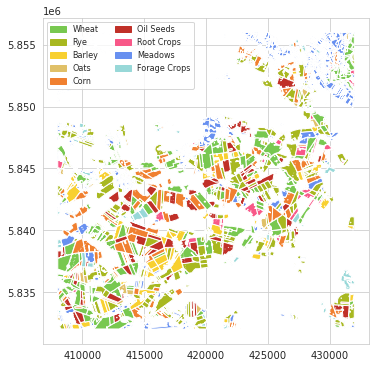

In [36]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

legend_elements = []

for group, color in zip(new_df.groupby('predicted_crop_id', sort=False), colors_list):
    print(group[0])
    group[1].plot(ax=ax, color=color)
    legend_elements.append(Patch(facecolor=color, edgecolor=color,label=ger_labels[group[0]-1]))
    
ax.legend(handles=legend_elements,loc=2, ncol=2, fontsize=8)

plt.savefig('../final/fig_germany_predictions_map.png', dpi=150, bbox_inches="tight")